# Customer Transaction Prediction

In [1]:
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from time import time
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler

In [2]:
# Reading training data
data_set_train = pd.read_csv("./train.csv")
trainData_X = data_set_train.drop(['ID_code', 'target'], axis = 1)
trainData_Y = data_set_train['target']

# Data Exploration

In [3]:
# Check null data
data_set_train.isnull().any().any()

False

In [4]:
trainData_X.head()

,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,-4.9200,5.7470,...,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,3.1468,8.0851,...,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
2,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,-4.9193,5.9525,...,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965
3,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,-5.8609,8.2450,...,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996
4,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,6.2654,7.6784,...,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104


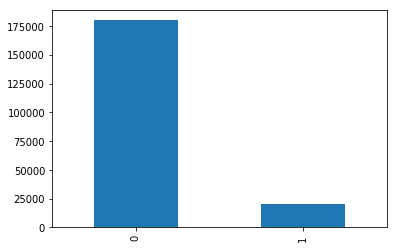

In [7]:
data_set_train['target'].value_counts().plot.bar();

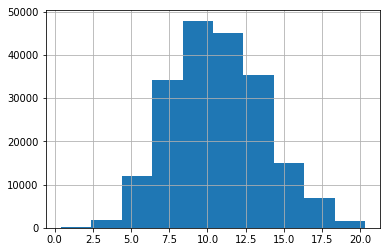

In [6]:
data_set_train["var_0"].hist();

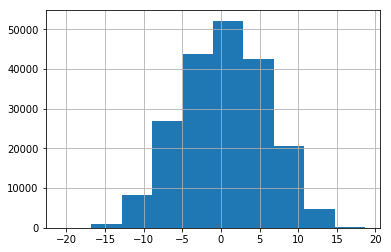

In [8]:
data_set_train["var_10"].hist();

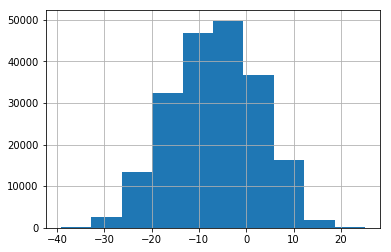

In [9]:
data_set_train["var_100"].hist();

# Data Preprocessing

In [4]:
# Create training and validation set
X_train, X_test, y_train, y_test = train_test_split(trainData_X, trainData_Y, test_size = 0.2)

# Convert the pandas dataframe to numpy array
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

# OverSampling
ros = RandomOverSampler(random_state=0)
X_train_sampled, y_train_sampled = ros.fit_resample(X_train, y_train)

# Standardize the data
StandardScaler = preprocessing.StandardScaler().fit(X_train_sampled)
X_train_sampled = StandardScaler.transform(X_train_sampled)
X_test_sampled = StandardScaler.transform(X_test)

StandardScaler = preprocessing.StandardScaler().fit(X_train)
X_train = StandardScaler.transform(X_train)
X_test = StandardScaler.transform(X_test)

In [4]:
print("X training: ", X_train_sampled.shape)
print("y_training: ", y_train_sampled.shape)

print("X testing: ", X_test.shape)
print("y_testing: ", y_test.shape)

X training:  (287836, 200)
y_training:  (287836,)
X testing:  (40000, 200)
y_testing:  (40000,)


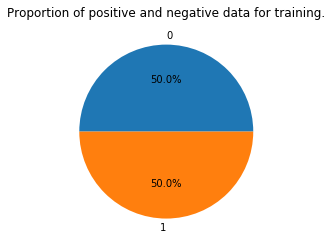

In [57]:
plt.pie([np.sum(y_train_sampled == 0), np.sum(y_train_sampled == 1)], labels = ["0", "1"], autopct='%1.1f%%');
plt.title("Proportion of positive and negative data for training.");

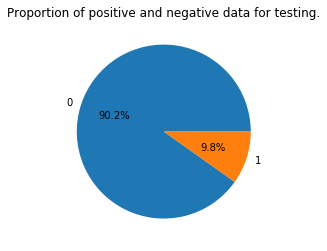

In [58]:
plt.pie([np.sum(y_test == 0), np.sum(y_test == 1)], labels = ["0", "1"], autopct='%1.1f%%');
plt.title("Proportion of positive and negative data for testing.");

# Model 1 - SVM

In [61]:
# Prepare data for SVM
X_train_svm = X_train
X_test_svm = X_test

y_train_svm = y_train
y_train_svm = np.array([-1 if y == 0 else 1 for y in y_train_svm]).reshape(-1, 1)

y_test_svm =  y_test
y_test_svm = np.array([-1 if y == 0 else 1 for y in y_test_svm]).reshape(-1, 1)

In [62]:
svm_Graph = tf.Graph()

# Basic settings
svm_batch_size = 5000
n_features = 200

In [63]:
# Build the graph
with svm_Graph.as_default():
    
    with tf.name_scope("Variables"):
        global_step = tf.Variable(0, dtype=tf.int32, trainable=False, name="global_step")
    
    # Get input
    with tf.name_scope("Input"):
        # Initialize placeholders
        x_data = tf.placeholder(shape=[None, n_features], dtype=tf.float32)
        y_target = tf.placeholder(shape=[None, 1], dtype=tf.float32)
        prediction_grid = tf.placeholder(shape=[None, n_features], dtype=tf.float32)

        # Create variables for svm
        b = tf.Variable(tf.random_normal(shape=[1, svm_batch_size]))
    
    # Define gaussion kernel
    with tf.name_scope("Gaussion_Kernel"):
        gamma = tf.constant(-10.0)
        dist = tf.reduce_sum(tf.square(x_data), 1)
        dist = tf.reshape(dist, [-1,1])
        sq_dists = tf.add(tf.subtract(dist, tf.multiply(2.,tf.matmul(x_data, tf.transpose(x_data)))),
                          tf.transpose(dist))
        my_kernel = tf.exp(tf.multiply(gamma, tf.abs(sq_dists)))
        
    # Measuring the dual to compute loss
    with tf.name_scope("Dual_Measuring"):
        first_term = tf.reduce_sum(b)
        b_vec_cross = tf.matmul(tf.transpose(b), b)
        y_target_cross = tf.matmul(y_target, tf.transpose(y_target))
        second_term = tf.reduce_sum(tf.multiply(my_kernel, tf.multiply(b_vec_cross, y_target_cross)))
        loss = tf.negative(tf.subtract(first_term, second_term))
        
    # Make prediction
    with tf.name_scope("Predict_and_Accuracy"):
        rA = tf.reshape(tf.reduce_sum(tf.square(x_data), 1), [-1,1])
        rB = tf.reshape(tf.reduce_sum(tf.square(prediction_grid), 1), [-1,1])
        pred_sq_dist = tf.add(tf.subtract(rA, tf.multiply(2., tf.matmul(x_data, tf.transpose(prediction_grid)))), 
                              tf.transpose(rB))
        pred_kernel = tf.exp(tf.multiply(gamma, tf.abs(pred_sq_dist)))

        prediction_output = tf.matmul(tf.multiply(tf.transpose(y_target), b), pred_kernel)
        prediction = tf.sign(prediction_output - tf.reduce_mean(prediction_output))
        accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.squeeze(prediction), tf.squeeze(y_target)), tf.float32))
        
    # Optimizer
    with tf.name_scope("optimizer"):
        my_opt = tf.train.GradientDescentOptimizer(0.001)
        train_step = my_opt.minimize(loss)
    
    # Summary
    with tf.name_scope("Summary"):
        tf.summary.scalar('Loss', loss)
        tf.summary.scalar('Training_Accuracy', accuracy)
    
    # Global options
    with tf.name_scope("global_ops"):
        init = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer())
        merged_summary = tf.summary.merge_all()
        increment_step = global_step.assign_add(1)
        

In [65]:
with tf.Session(graph = svm_Graph) as sess:
    writer_svm = tf.summary.FileWriter("./", svm_Graph)
    sess.run(init)

    for i in range(50):
        
        total_batch_svm = int(len(X_train_svm) / svm_batch_size)
        x_batches_svm = np.array_split(X_train_svm, total_batch_svm)
        y_batches_svm = np.array_split(y_train_svm, total_batch_svm)
        
        for j in range(total_batch_svm):
            
            feed_dict_train_batch = {x_data: x_batches_svm[j], 
                                     y_target: y_batches_svm[j]}
            
            sess.run(train_step, feed_dict=feed_dict_train_batch)
            
            l = sess.run(loss, feed_dict=feed_dict_train_batch)
            acc, summary, step = sess.run([accuracy, merged_summary, increment_step], 
                                          feed_dict={x_data: x_batches_svm[j], 
                                                     y_target: y_batches_svm[j], 
                                                     prediction_grid: x_batches_svm[j]})
            
            writer_svm.add_summary(summary, global_step=step)
            
        if i % 10 == 0:
            print('Train loss = ' + str(l), "Train accuracy: ", acc)
            
    writer_svm.flush()
    writer_svm.close()

Train loss = 4186.1187 Train accuracy:  0.4954
Train loss = 259.5078 Train accuracy:  0.5652
Train loss = -830.83813 Train accuracy:  0.647
Train loss = -1133.6068 Train accuracy:  0.763
Train loss = -1217.6797 Train accuracy:  0.912


# Model 2 - A Simple Neural Network

In [5]:
# Prepare data for NN
X_train_nn = X_train_sampled
X_test_nn = X_test_sampled

y_train_nn = y_train_sampled.reshape(-1, 1)
y_test_nn = y_test.reshape(-1, 1)

# One Hot Encoder
oneHot = OneHotEncoder(categories='auto')
oneHot.fit(y_train_nn)
y_train_nn = 1 - oneHot.transform(y_train_nn).toarray()

oneHot.fit(y_test_nn)
y_test_nn = 1 - oneHot.transform(y_test_nn).toarray()

In [6]:
nn_Graph = tf.Graph()

# Specify some constant value
n_hidden_1 = 50
n_hidden_2 = 25
n_features = 200

nn_batch_size = 1000

In [10]:
with nn_Graph.as_default():
    # Define the model
    def Net(x):
        with tf.name_scope("Layer_1"):
            
            with tf.name_scope("weights"):
                w1 = tf.Variable(tf.random_normal([n_features, n_hidden_1]), name = "W1")
                b1 = tf.Variable(tf.random_normal([n_hidden_1]), name = "b1")
            
            layer_1 = tf.add(tf.matmul(x, w1), b1)
            layer_1 = tf.layers.batch_normalization(layer_1)
            layer_1 = tf.nn.leaky_relu(layer_1)
        
        with tf.name_scope("Layer_2"):
            
            with tf.name_scope("weights"):
                w2 = tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2]), name = "W2")
                b2 = tf.Variable(tf.random_normal([n_hidden_2]), name = "b2")
                
            layer_2 = tf.add(tf.matmul(layer_1, w2), b2)
            layer_2 = tf.layers.batch_normalization(layer_2)
            layer_2 = tf.nn.leaky_relu(layer_2)
        
        with tf.name_scope("Output_Layer"):
            
            with tf.name_scope("weight"):
                w3 = tf.Variable(tf.random_normal([n_hidden_2, 2]), name = "W3")
                b3 = tf.Variable(tf.random_normal([2]), name = "b3")
                
            logits = tf.add(tf.matmul(layer_2, w3), b3)
            
        return logits
    
    with tf.name_scope("Input_Layer"):
        # Placeholder for X and Y values
        x = tf.placeholder("float", [None, n_features], name = "X")
        y = tf.placeholder("float", [None, 2], name = "y")
            
    # Initialize the model
    global_step = tf.Variable(0, dtype=tf.int32, trainable=False, name="global_step")
    logits = Net(x)
    y_pred = tf.nn.softmax(logits, name = "y_pred")
    
    with tf.name_scope("Loss_and_Accuracy"):
        # Loss
        loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = logits, labels = y), name = "Loss")
        
        # Accuracy
        accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(y_pred, 1), tf.argmax(y, 1)), tf.float32))
        
        # Confusion matrix
        confusion_matrix = tf.confusion_matrix(tf.argmax(logits, 1), tf.argmax(y, 1 ))
        
    with tf.name_scope("AUC"):
        auc, auc_update_op = tf.metrics.auc(predictions = y_pred, labels = y, curve = 'ROC')
        auc_variables = [ v for v in tf.local_variables() if v.name.startswith( "AUC" ) ]
        auc_reset_op = tf.initialize_variables(auc_variables)
    
    # Optimizer
    lr = tf.train.exponential_decay(0.001, global_step, 10000, 0.95, staircase=True)
    optimizer = tf.train.AdamOptimizer(learning_rate = lr).minimize(loss)
    
    with tf.name_scope("Summary"):
        # Summary
        summaries_train = [tf.summary.scalar('Loss', loss), 
                           tf.summary.scalar('Training_Accuracy', accuracy),
                           tf.summary.scalar('Training_AUC', auc_update_op)]
        summaries_test = [tf.summary.scalar('Testing_Accuracy', accuracy),
                          tf.summary.scalar('Testing_AUC', auc_update_op)]
    
    # Global options
    with tf.name_scope("global_ops"):
        merged_train = tf.summary.merge(summaries_train)
        merged_test = tf.summary.merge(summaries_test)
        increment_step = global_step.assign_add(1)

In [8]:
def show_progress(epoch, feed_dict_train, feed_dict_test, loss):
    acc, auc_value = sess.run([accuracy, auc_update_op], feed_dict = feed_dict_train)
    sess.run(auc_reset_op)
    test_acc, test_auc_value = sess.run([accuracy, auc_update_op], feed_dict = feed_dict_test)
    sess.run(auc_reset_op)
    msg = 'Training Epoch {} - Train Acc: {:>6.1%}, Train AUC: {:>6.1%}, Test Acc: {:>6.1%}, Test AUC: {:>6.1%}, Loss: {:.6f}'
    print(msg.format(epoch + 1, acc, auc_value, test_acc, test_auc_value, loss))
    
        
def train(num_iteration):
    for i in range(0, num_iteration):
        
        total_batch = int(len(X_train_nn) / nn_batch_size)
        feed_dict_train = {x: X_train_nn, y: y_train_nn}
        feed_dict_test = {x: X_test_nn, y: y_test_nn}
        
        for j in range(total_batch):
            x_batches = np.array_split(X_train_nn, total_batch)
            y_batches = np.array_split(y_train_nn, total_batch)

            feed_dict_train_batch = {x: x_batches[j], y: y_batches[j]}

            _, auc, s = sess.run([optimizer, auc_update_op, increment_step], feed_dict = feed_dict_train_batch)
        
        l, summary_train = sess.run([loss, merged_train], feed_dict = feed_dict_train)
        writer_nn.add_summary(summary_train, global_step=s)
        
        sess.run(auc_reset_op)
        summary_test = sess.run(merged_test, feed_dict = feed_dict_test)
        writer_nn.add_summary(summary_test, global_step=s)
        
        if i % 10 == 0:
            show_progress(i/100, feed_dict_train, feed_dict_test, l)
    
    print("Train: \n", confusion_matrix.eval(feed_dict_train))
    print("Test: \n", confusion_matrix.eval(feed_dict_test))

In [9]:
with tf.Session(graph = nn_Graph) as sess:
    writer_nn = tf.summary.FileWriter('./', nn_Graph)
    init = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer())
    sess.run(init) 
    train(num_iteration = 1000)
    writer_nn.flush()
    writer_nn.close()

Training Epoch 1.0 - Train Acc:  54.8%, Train AUC:  50.7%, Test Acc:  21.8%, Test AUC:  21.5%, Loss: 59.301781
Training Epoch 1.1 - Train Acc:  59.7%, Train AUC:  56.3%, Test Acc:  29.0%, Test AUC:  27.6%, Loss: 9.883902
Training Epoch 1.2 - Train Acc:  59.6%, Train AUC:  57.3%, Test Acc:  28.0%, Test AUC:  24.7%, Loss: 3.109306
Training Epoch 1.3 - Train Acc:  60.9%, Train AUC:  62.2%, Test Acc:  30.0%, Test AUC:  25.7%, Loss: 1.316013
Training Epoch 1.4 - Train Acc:  66.1%, Train AUC:  68.6%, Test Acc:  40.2%, Test AUC:  36.2%, Loss: 0.949088
Training Epoch 1.5 - Train Acc:  69.2%, Train AUC:  72.4%, Test Acc:  46.4%, Test AUC:  43.7%, Loss: 0.831571
Training Epoch 1.6 - Train Acc:  69.8%, Train AUC:  73.7%, Test Acc:  47.1%, Test AUC:  46.5%, Loss: 0.794701
Training Epoch 1.7 - Train Acc:  71.9%, Train AUC:  76.3%, Test Acc:  50.6%, Test AUC:  52.0%, Loss: 0.729979
Training Epoch 1.8 - Train Acc:  72.4%, Train AUC:  77.1%, Test Acc:  51.0%, Test AUC:  52.8%, Loss: 0.707675
Training 

Training Epoch 8.5 - Train Acc:  89.7%, Train AUC:  92.9%, Test Acc:  75.4%, Test AUC:  81.9%, Loss: 0.293480
Training Epoch 8.6 - Train Acc:  89.7%, Train AUC:  92.9%, Test Acc:  75.3%, Test AUC:  81.9%, Loss: 0.293891
Training Epoch 8.7 - Train Acc:  89.9%, Train AUC:  93.1%, Test Acc:  75.7%, Test AUC:  82.2%, Loss: 0.286914
Training Epoch 8.8 - Train Acc:  90.0%, Train AUC:  93.2%, Test Acc:  75.8%, Test AUC:  82.4%, Loss: 0.285118
Training Epoch 8.9 - Train Acc:  89.9%, Train AUC:  93.1%, Test Acc:  75.6%, Test AUC:  82.1%, Loss: 0.288589
Training Epoch 9.0 - Train Acc:  90.0%, Train AUC:  93.2%, Test Acc:  75.8%, Test AUC:  82.3%, Loss: 0.285079
Training Epoch 9.1 - Train Acc:  90.2%, Train AUC:  93.3%, Test Acc:  76.1%, Test AUC:  82.6%, Loss: 0.280058
Training Epoch 9.2 - Train Acc:  90.2%, Train AUC:  93.3%, Test Acc:  76.1%, Test AUC:  82.6%, Loss: 0.279253
Training Epoch 9.3 - Train Acc:  90.2%, Train AUC:  93.4%, Test Acc:  76.1%, Test AUC:  82.6%, Loss: 0.278977
Training E